In [193]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
from poll_data import party_in_region, region_in_party
import pickle
import matplotlib.pyplot as plt
#https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

## Stat data

In [194]:
path = 'dane_years/'
files = list(filter(lambda x: os.path.isfile(path+x), os.listdir(path)))
files.sort()

In [195]:
stat_list = [(lambda x: pd.read_csv(path+x,index_col=0, header=0))(f) for f in files]

In [196]:
stat_list[0].columns[stat_list[0].isna().sum(0) > 0]

Index(['bezrobocie_zarejsestrowane_gminy', 'ludnosc_na_1km2',
       'dochody_na_mieszkanca', 'wyksztalcenie_wyzsze',
       'udzial_wiek_przedprodukcyjny', 'udzial_wiek_produkcyjny',
       'udzial_wiek_poprodukcyjny', 'socjal_500plus', 'przestepstwa_ogolem'],
      dtype='object')

In [211]:
col_not_na0 = stat_list[0].columns[stat_list[0].isna().sum(0) == 0]
col_not_na17 = stat_list[0].columns[stat_list[17].isna().sum(0) == 0]

In [218]:
for st in range(len(stat_list)):
    stat_list[st] = stat_list[st][col_not_na0]
    # min max normalization
    stat_list[st] = (stat_list[st]-stat_list[st].min(0)) /(stat_list[st].max(0)-stat_list[st].min(0))

## Poll data

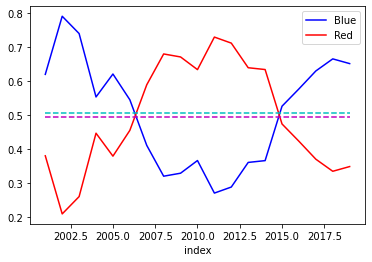

In [223]:
#pool_data = pd.read_csv('dane_years/pools_edited.csv', index_col=0)
pool_data_middle = pd.read_csv('dane_years/pools_data/no_votes.csv', index_col=0).iloc[:,:-1]
pool_data_middle = pool_data_middle.divide(pool_data_middle.sum(1),0)
pool_data_middle.plot(color=['b','r'])
means = pool_data_middle.mean(0)
plt.plot([2001,2019],[means[0],means[0]],'c--')
plt.plot([2001,2019],[means[1],means[1]],'m--')
plt.show()

## Voting data

In [224]:
path = 'wyniki_wyborow/Simple/'
files = list(filter(lambda x: os.path.isfile(path+x), os.listdir(path)))
files.sort()
files

['2001_WS.csv',
 '2005_WS.csv',
 '2007_WS.csv',
 '2011_WS.csv',
 '2015_WS.csv',
 '2019_WS.csv']

In [225]:
vote_list = [(lambda x: pd.read_csv(path+x,index_col=0, header=0))(f) for f in files[:]]
vote_list[0] = vote_list[0].iloc[1:,:]

In [226]:
vote_list[0]['jednostka'] = [j.upper() for j in vote_list[0]['jednostka']]
vote_list[0] = vote_list[0].sort_values(['jednostka'])
vote_list[0].columns = ['województwo'] + vote_list[0].columns.values.tolist()[1:] 

In [227]:
vote_list[0] = vote_list[0].set_index('województwo')

## Neighbours

In [228]:
with open('wojew_neighbours.pkl', 'rb') as f:
    neighbours = pickle.load(f)

## Use 2 approaches to estimate date from years without elections

In [229]:
#party_in_region(df_vote, df_poll)
par_in_reg_list = [vote_list[0].iloc[:,:-1]]
#region_in_party(df_vote, df_poll)
reg_in_par_list = [vote_list[0].iloc[:,:-1]]
for pool in pool_data_middle[1:].iterrows():
    if int(pool[0]) < 2005: df_vote = vote_list[0]
    elif int(pool[0]) < 2007: df_vote = vote_list[1]
    elif int(pool[0]) < 2011: df_vote = vote_list[2]
    elif int(pool[0]) < 2015: df_vote = vote_list[3]
    elif int(pool[0]) < 2019: df_vote = vote_list[4]
    else: df_vote = vote_list[5]
    
    par_in_reg_list.append(party_in_region(df_vote.iloc[:,:-1], pool[1]))
    reg_in_par_list.append(region_in_party(df_vote.iloc[:,:-1], pool[1]))

In [230]:
for vl, i in zip(vote_list.copy(),[0,4,6,10,14,18]):    
    par_in_reg_list[i] = vl.iloc[:,:-1]
    reg_in_par_list[i] = vl.iloc[:,:-1]

## Prepare input (X) (parameters which we will multiply)
Input - wagi, <br>
na outpucie mnożenie wag razy wartości i na tej podstawie ocena.
- poprzednie wybory (par in reg/ reg in par)
- wpływ sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

In [231]:
pool_d = par_in_reg_list if (True) else reg_in_par_list 

In [235]:
X = []
# iterate over years [from 2002 - 2019]
for y in range(len(stat_list)):
    # iterate over districts
    tmp_x = []
    st_data = stat_list[y]
    for d in range(vote_list[0].shape[0]):
        # 1. last election: Blue, Red
        #    Blue/All
        # 2. neighbours
        # 3. one (1)
        lo = pool_d[y].iloc[d,:]
        neigh = neighbours[lo.name.lower()]
        avg_n = [pool_d[y].loc[n.upper()][0]/pool_d[y].loc[n.upper()].sum() for n in neigh]
        avg_n = sum(avg_n)/len(neigh)
        
        tmp_y = st_data.iloc[d,:].values.tolist()
        tmp_y.append(lo[0]/lo.sum())
        tmp_y.append(avg_n)
                
        tmp_x.append(tmp_y)
    X.append(tmp_x)

In [237]:
X = np.array(X)
X.shape

(18, 16, 13)

## Prepare Y

In [241]:
Y = []
for y in range(1,pool_data_middle.shape[0]):
    # iterate over districts
    tmp_y = []
    for d in range(vote_list[0].shape[0]):
        # 1. last election: Blue, Red, Gray
        #    Blue/All
        # 2. neighbours
        # 3. one (1)
        lo = pool_d[y].iloc[d,:]
        tmp_y.append([lo[0]/lo.sum()])
    Y.append(tmp_y)

In [242]:
Y = np.array(Y)
Y.shape

(18, 16, 1)

## Parameters to be estimated
- waga poprzednie wybory
- waga wpływu sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

## Process
- input,
- warstwy,
- output (parametry lub wagi),
- output\*parameters (the real output - wynik wyborów)

**OR**
- input (parameters),
- simple network to get the weight = parameters to multiply,
- output (next election)

## Training phase (looking for parameters)

Functions for models

In [243]:
X.shape

(18, 16, 13)

### Models with percentage of Blue support per district

In [244]:
def model_percent(a,x):
    '''
    INPUT:
    a - vector of weights 16x14
    x - vector of input data 18x16x14
    OUTPUT:
    y - predicted value in (0,1)
    '''
    d0 = x.shape[0] if (len(x.shape) == 3) else 1
    d1 = x.shape[-1] 
    
    a = np.repeat(a, d0, 0)
    x = x.reshape(-1, d1)
    #return 1 / (1+np.exp(-np.sum(x.dot(a.T))))
    y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))
    return y

def grad_percent(a,x):
    '''
    INPUT:
    a - vector of weights 16x14
    x - vector of input data 18x16x14
    '''
    #return a * np.exp(-x.T.dot(a)) / (1+np.exp(-x.T.dot(a)))**2
    #return a*np.exp(-np.sum(x*a,1,keepdims=True)) / (1+np.exp(-np.sum(x*a,1,keepdims=True)))**2
    d0 = x.shape[0] if (len(x.shape) == 3) else 1
    d1 = x.shape[-1] 
    
    a = np.repeat(a, d0, 0)
    x = x.reshape(-1, d1)
    y = a*np.exp(-np.sum(x.dot(a.T),1,keepdims=True)) / (1+np.exp(-np.sum(x.dot(a.T),1,keepdims=True)))**2
    return y

In [245]:
loss_p = np.inf
loss_v = np.inf

a_avg = np.random.rand(X.shape[1],X.shape[2])
a_all = a_avg
#av = np.random.rand(X.shape[1],X.shape[2])

step = 0.001
beta = 0.01
a_avg.shape

(16, 13)

## All at once

In [249]:
for epoch in range(10**3):
    grad = grad_percent(a_avg,X).reshape(X.shape[0],X.shape[1],-1)
    grad = np.sum(grad, axis=0)
    a_avg = a_avg - step*grad
    
    #if epoch%50==0: 
    #    if np.sum((model_percent(ap,X) - Y.reshape(-1,1))**2) < loss_p: step *= (1+beta)
    #    else: step /= (1-beta)

    loss_p = np.sum((model_percent(a_avg,X) - Y.reshape(-1,1))**2)

    if epoch%100==0: 
        print('loss sum:',loss_p)
a_avg.shape

loss sum: 56.154771813340496
loss sum: 56.154771813340496
loss sum: 56.154771813340496
loss sum: 56.154771813340496
loss sum: 56.154771813340496
loss sum: 56.154771813340496
loss sum: 56.154771813340496
loss sum: 56.154771813340496
loss sum: 56.154771813340496
loss sum: 56.154771813340496


(16, 13)

### Shuffle years and on at once

In [252]:
for epoch in range(10**5):
    shuffle_i = np.arange(X.shape[0])
    np.random.shuffle(shuffle_i)
    loss_p = 0
    for i in shuffle_i:
        grad = grad_percent(a_all,X[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_all = a_all - step*grad

        #if epoch%50==0: 
        #    if np.sum((model_percent(ap,X) - Y.reshape(-1,1))**2) < loss_p: step *= (1+beta)
        #    else: step /= (1-beta)

        loss_p += np.sum((model_percent(a_all,X[i]) - Y[i].reshape(-1,1))**2)

    if epoch%10000==0: 
        print('loss sum:',loss_p)
a_all.shape

loss sum: 56.71547727762272
loss sum: 56.71538329454552
loss sum: 56.715289315093116
loss sum: 56.715195333956615
loss sum: 56.71510135186026
loss sum: 56.71500737681996
loss sum: 56.71491340601665
loss sum: 56.714819429269035
loss sum: 56.71472546001472
loss sum: 56.71463149368483


(16, 13)

## All at once + evolution strategies (TO DO)

# https://towardsdatascience.com/introduction-to-evolution-strategy-1b78b9d48385
for epoch in range(10**3):
    grad = grad_percent(a_avg,X).reshape(18,16,3)
    grad = np.sum(grad, axis=0)
    a_avg = a_avg - step*grad
    
    #if epoch%50==0: 
    #    if np.sum((model_percent(ap,X) - Y.reshape(-1,1))**2) < loss_p: step *= (1+beta)
    #    else: step /= (1-beta)

    loss_p = np.sum((model_percent(a_avg,X) - Y.reshape(-1,1))**2)

    if epoch%100==0: 
        print('loss sum:',loss_p)
a_avg.shape

### Setup for testing model

In [261]:
neigh_ndx = []
for d in range(X.shape[1]):
    # 1. last election: Blue, Red, Gray
    #    Blue/All
    # 2. neighbours
    # 3. one (1)
    lo = par_in_reg_list[0].iloc[d,:]        
    neigh = neighbours[lo.name.lower()]
    indexs = par_in_reg_list[0].index.values
    neigh_ndx.append(np.searchsorted(indexs, np.char.upper(neigh)))

In [262]:
def prepare_input(y, st_data):
    tmp_x = np.zeros((y.shape[0],13))
    for d in range(y.shape[0]):
        neigh = neigh_ndx[d]
        avg_n = [y[n,0]/np.sum(y[neigh,0]) for n in neigh]
        avg_n = sum(avg_n)/len(neigh)
        
        tmp_y = st_data.iloc[d,:].values.tolist()
        tmp_y.append(y[d,0])
        tmp_y.append(avg_n)
        
        tmp_x[d] = np.array(tmp_y)
    return(tmp_x)

In [263]:
def model(a,x,Y):
    y = Y[0]
    loss = []
    out = np.zeros(Y.shape)
    out[0] = y
    for year in range(1,X.shape[0]):
        st_data = stat_list[year-1]
        xi = prepare_input(y,st_data)
        y = model_percent(a,xi)
        loss.append(np.sum((y - Y[year])**2))
        #print(y.shape,'loss:', np.sum((y - Y[year])**2))
        out[year] = y
    return loss, out

[]

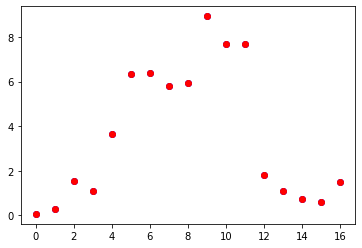

In [264]:
l_avg, o = model(a_avg,X,Y)
l_all, o = model(a_all,X,Y)
plt.plot(l_avg,'bo')
plt.plot(l_all,'ro')
plt.plot()

## Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)
https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/ <br>
http://proceedings.mlr.press/v57/zhao16.pdf <br>
https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816 <br>
https://developer.apple.com/documentation/coreml/core_ml_api/making_predictions_with_a_sequence_of_inputs <br>
https://www.youtube.com/watch?v=WCUNPb-5EYI

In [56]:
(a_avg-a_all).max()

0.004963590920596506